In [2]:
import _pickle as pickle
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# Load raw data 
X_train = np.load("data\\X_train.npy")
Y_train = np.load("data\\Y_train.npy")
X_test = np.load("data\\X_test.npy")
Y_test = np.load("data\\Y_test.npy")
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)

(27392, 150, 150, 3) (27392, 25)
(3076, 150, 150, 3) (3076, 25)


In [4]:
# Rescale features
X_train = (X_train / 255) * 2.0 - 1.0
X_test = (X_test / 255) * 2.0 - 1.0 

In [5]:
import keras
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, Conv2D
from keras.models import Model, Sequential, model_from_yaml 
from keras import applications, optimizers
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [6]:
from keras.models import Sequential, load_model
weights_path = 'VGG16_weights_aug.h5'
# load json and create model
yaml_file = open('fine_tune_VGG_model_aug.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(weights_path)

print("Loaded model from disk")
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print('Layer dict', layer_dict)
print(model.summary())

Loaded model from disk
Layer dict {'input_1': <keras.engine.topology.InputLayer object at 0x17b071048>, 'block1_conv1': <keras.layers.convolutional.Conv2D object at 0x17b0710b8>, 'block1_conv2': <keras.layers.convolutional.Conv2D object at 0x17b071630>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x17b071320>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x17b0714e0>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x17b0719b0>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x17b071f28>, 'block3_conv1': <keras.layers.convolutional.Conv2D object at 0x17b071c50>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x16f33bda0>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x17b06d358>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x17b06d4e0>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x17b06d4a8>, 'block4_conv2': <keras.layers.convolutional.Conv2D object at 0x17b06d710>,

# Visualize filter implementation

(1, 150, 150, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


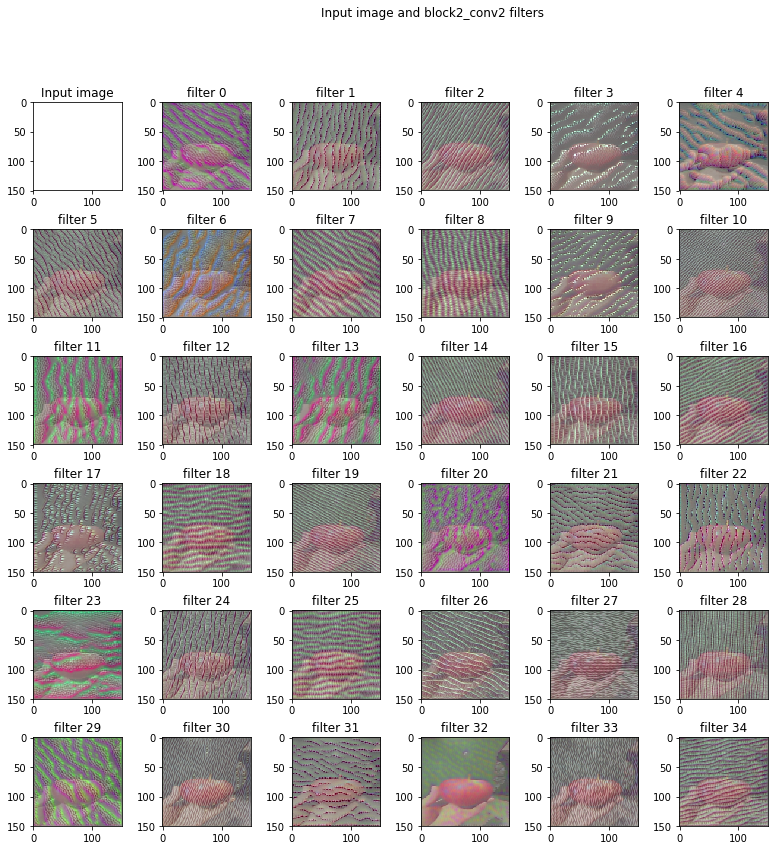

In [7]:
from keras import backend as K
K.set_learning_phase(1)

from keras.preprocessing import image
apple_img = image.img_to_array(image.load_img(path="data/train/apple_0.png",
                                              target_size=(150,150,3))).reshape((-1,150,150,3))

def normalize_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def visualize_filter(img = np.array(X_test[0].reshape((-1, 150, 150, 3)).astype(np.float64)), 
                     layer_name = 'block2_conv2'):
    layer_output = layer_dict[layer_name].output
    print(img.shape)
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        if filter_index > 35:
            break
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step
        img_asc = img_asc[0]
        img_ascs.append(normalize_image(img_asc).reshape((150, 150,3)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((150, 150,3)))
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        try:
            an_img = img_ascs[x * plot_y + y - 1]
        except:
            break
        ax[x, y].imshow(an_img, cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

visualize_filter(apple_img)
plt.show()